In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
import numpy as np

from PIL import Image
import tiktoken
from dataclasses import dataclass
from datasets import load_dataset

import os, io, tarfile

import matplotlib.pyplot as plt

In [2]:
# ------------------------------
# Shared Transformer Blocks
# ------------------------------

# moved to clip.py
from clip import MLP, Attention, Block

# class MLP(nn.Module):
#     """linear layer + non-linearity to add compute after multi-head attention"""

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # expand onto higher dimensional space
#         self.gelu = nn.GELU(approximate='tanh')
#         self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd) # project back down to model's embedding dimensionality 

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         return x

# class Attention(nn.Module):
#     """multiple self-attention heads in parallel"""

#     def __init__(self, config):
#         super().__init__()
#         assert config.n_embd % config.n_head == 0
#         # key, query, value projections for all heads, batched together
#         self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
#         # output projection
#         self.c_proj = nn.Linear(config.n_embd, config.n_embd)

#         self.n_head = config.n_head
#         self.n_embd = config.n_embd
#         self.is_decoder = config.is_decoder


#     def forward(self, x):
#         B, T, C = x.shape # batch size, sequence length, n_embd
#         # calculate query, key, value for all heads in a batch
#         # C = n_head * head_size, eg n_head = 12, head_size = 64, so C = 768
#         qkv = self.c_attn(x)
#         q, k, v = qkv.split(self.n_embd, dim=2)
#         k = k.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
#         q = q.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
#         v = v.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
        
#         # use flash attention instead of manually implemented attention
#         y = F.scaled_dot_product_attention(q, k, v, is_causal=self.is_decoder) # (B, n_head, T, head_size)
        
#         y = y.transpose(1, 2).reshape(B, T, -1) # (B, n_head, T, head_size) -> (B, T, n_head * head_size)

#         y = self.c_proj(y) 
#         return y

# class Block(nn.Module):
#     """transformer block: communication followed by computation, with resid connection (x +)"""

#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = nn.LayerNorm(config.n_embd)
#         self.attn = Attention(config)
#         self.ln_2 = nn.LayerNorm(config.n_embd)
#         self.mlp = MLP(config) 

#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x))
#         x = x + self.mlp(self.ln_2(x))
#         return x

In [3]:
# ------------------------------
# Text Decoder (GPT-style)
# ------------------------------

@dataclass
class TextConfig:
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 512
    out_dim: int = 512
    is_decoder: bool = True
    block_size: int = 77
    vocab_size: int = 50258 # from TextTokenizer

# moved to clip.py
from clip import TextDecoder

# class TextDecoder(nn.Module):
#     """GPT-style transformer decoder for text embeddings."""

#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         self.transformer = nn.ModuleDict(dict(
#             wte = nn.Embedding(config.vocab_size, config.n_embd),
#             wpe = nn.Embedding(config.block_size, config.n_embd),
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = nn.LayerNorm(config.n_embd),
#         ))
#         self.proj = nn.Linear(config.n_embd, config.out_dim, bias=False)

#         self.apply(self._init_weights)

#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             std = 0.02
#             torch.nn.init.normal_(module.weight, mean=0.0, std=std)
#             if module.bias is not None:
#                 torch.nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
#         # Use pytorch default LayerNorm init

#     def forward(self, idx, targets=None):
#         B, T = idx.shape
#         assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        
#         # idx and targets are both (B, T) tensor of integers
#         token_emb = self.transformer.wte(idx) # (B, T, C = n_embd)
#         pos_emb = self.transformer.wpe(torch.arange(T, device=idx.device)) # (T, C = n_embd)
#         x = token_emb + pos_emb # (B, T, C = n_embd)
#         for block in self.transformer.h:
#             x = block(x) # (B, T, C = n_embd)
#         x = self.transformer.ln_f(x)
#         # Find first occurrence of eot_token_id (50256)
#         # TODO: don't hardcode EOT token id
#         eot_positions = (idx == 50256).int().argmax(dim=-1)  # (B,)
#         eot_token = x[torch.arange(x.shape[0], device=idx.device), eot_positions]  # (B, C = n_embd)
#         out = self.proj(eot_token) # (B, C = out_dim)
#         out = out / out.norm(dim=-1, keepdim=True) # normalize to unit length for cosine similarity

#         return out

In [4]:
# ------------------------------
# Text Tokenizer
# ------------------------------

# moved to clip.py
from clip import TextTokenizer

# class TextTokenizer: 
#     """ 
#     tiktoken Wrapper
#     Not quite CLIP tokenizer, but approximates it using GPT-2 tokenizer 
#     Vocab size = GPT-2 vocab size (50257) + 1 (for new SOT token) = 50258
#     """

#     def __init__(self, config):
#         self.enc = tiktoken.get_encoding("gpt2")
#         # Special tokens
#         self.eot_token = "<|endoftext|>"
#         self.pad_token = self.eot_token
#         self.sot_token = "<|startoftext|>"
#         self.eot_token_id = 50256 # already exists in GPT-2 tokenizer
#         self.pad_token_id = self.eot_token_id
#         self.sot_token_id = self.eot_token_id + 1 # doesn't exist in GPT-2 tokenizer
        
#         self.block_size = config.block_size

#     def encode(self, text):
#         tokens = [self.sot_token_id]
#         text_enc = self.enc.encode(text)
#         if len(text_enc) + 2 > self.block_size:
#             tokens.extend(text_enc[:self.block_size - 2])
#         else:
#             tokens.extend(text_enc)
#             if len(tokens) < self.block_size:
#                 tokens.extend([self.pad_token_id] * (self.block_size - 1 - len(tokens)))
#         tokens.extend([self.eot_token_id])
#         return torch.tensor(tokens, dtype=torch.long)

#     def decode(self, ids, include_special_tokens=True):
#         result = ""
#         for id in ids.tolist():
#             if id == self.sot_token_id:
#                 if include_special_tokens:
#                     result += self.sot_token
#             elif id == self.eot_token_id:
#                 if include_special_tokens:
#                     result += self.eot_token
#             else:
#                 result += self.enc.decode([id])
#         return result

In [5]:
# ------------------------------
# Vision Encoder
# ------------------------------

@dataclass
class VisionConfig:
    n_layer: int = 8
    n_head: int = 6
    n_embd: int = 768
    out_dim: int = 512
    is_decoder: bool = False
    img_size: int = 224 # 224x224 image
    patch_size: int = 16 # 16x16 patches

# moved to clip.py
from clip import PatchEmbedding, VisionEncoder

# class PatchEmbedding(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.img_size = config.img_size
#         self.patch_size = config.patch_size
#         assert self.img_size % self.patch_size == 0
#         self.conv = nn.Conv2d(in_channels=3, out_channels=config.n_embd, kernel_size=self.patch_size, stride=self.patch_size)

#     def forward(self, x):
#         x = self.conv(x) # [B, C=3, S=224, S=224] -> [B, C=768, N=14, N=14] 
#         x = x.flatten(2) # [B, C=768, N=14, N=14] -> [B, C=768, N**2=T=196] 
#         x = x.transpose(1,2)  #[B, C, T] -> [B, T=196, C=768] 

#         return x

# class VisionEncoder(nn.Module):
#     """vision transformer encoder for image embeddings"""

#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         assert config.img_size % config.patch_size == 0
#         self.n_patch = (config.img_size // config.patch_size)**2 # N**2 = (224/16)**2 = 196
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, config.n_embd)) # extra learnable token
        
#         self.transformer = nn.ModuleDict(dict(
#             patch_emb = PatchEmbedding(config),
#             pos_emb = nn.Embedding(self.n_patch + 1, config.n_embd), # +1 for cls_token
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = nn.LayerNorm(config.n_embd),
#         ))
#         self.proj = nn.Linear(config.n_embd, config.out_dim, bias=False)

#         self.apply(self._init_weights)

#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             std = 0.02
#             torch.nn.init.normal_(module.weight, mean=0.0, std=std)
#             if module.bias is not None:
#                 torch.nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
#         # Use pytorch default LayerNorm & Conv2d init
        
#     def forward(self, x):
#         x = self.transformer.patch_emb(x) # [B, C=3, S=224, S=224] -> [B, T=196, C=768]
#         B, T, C = x.shape

#         # add cls_token to each batch
#         x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1) # [B, 197, C=768]
#         # add positional embedding
#         pos_emb = self.transformer.pos_emb(torch.arange(T+1, device=x.device)) # [197, C=768]
#         x = x + pos_emb # [B, 197, C=768]
#         for block in self.transformer.h:
#             x = block(x) # [B, 197, C=768]
#         x = self.transformer.ln_f(x) # [B, 197, C=768]
#         cls_token = x[:, 0, :] # [B, 197, C=768] -> [B, C=768]
#         out = self.proj(cls_token) # [B, C=768] -> [B, C=512]
#         out = out / out.norm(dim=-1, keepdim=True) # normalize to unit length for cosine similarity

#         return out

In [6]:
# Image utils

vision_config = VisionConfig()

# image to tensor
itot = transforms.Compose([
  transforms.Resize((vision_config.img_size, vision_config.img_size)),
  transforms.ToTensor()
])
# tensor to image
ttoi = transforms.ToPILImage()

# sample image loader
def load_image(name):
    dir = "./data/sample"
    file = f"{dir}/{name}"
    return itot(Image.open(file).convert("RGB"))

def show_tensor_image(image):
    image = ttoi(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [7]:
# ------------------------------
# Verify TextDecoder and VisionEncoder output shapes
# ------------------------------

# TextDecoder
text_config = TextConfig()
enc = TextTokenizer(text_config)
model = TextDecoder(text_config)

labels = torch.stack([
    enc.encode("a boy and a girl"),
    enc.encode("a red ball"),
    enc.encode("a boy and a girl playing soccer in the park with a red ball"),
    enc.encode("a tiny cat"),
    enc.encode("lorem ipsum dolor sit amet consectetur adipiscing elit sed do eiusmod tempor incididunt ut labore et dolore magna aliqua"),
    enc.encode("the lion goes roar when it is angry"),
])

print(f"labels minibatch shape (B, L=77): {labels.shape}")

label_emb = model(labels)
print(f"label_emb shape (B, C=512): {label_emb.shape}")
print()

# VisionEncoder
images = torch.stack([
    load_image("dog.jpg"),
    load_image("cat.jpg"),
    load_image("car.jpg"),
    load_image("truck.jpg"),
    load_image("girl.jpg"),
    load_image("boy.jpg"),
])

print(f"images minibatch shape (B, C=3, H=224, W=224): {images.shape}")

vision_encoder = VisionEncoder(vision_config)
image_emb = vision_encoder(images)

print(f"image_emb shape (B, C=512): {image_emb.shape}")


labels minibatch shape (B, L=77): torch.Size([6, 77])
label_emb shape (B, C=512): torch.Size([6, 512])

images minibatch shape (B, C=3, H=224, W=224): torch.Size([6, 3, 224, 224])
image_emb shape (B, C=512): torch.Size([6, 512])


In [8]:
# ------------------------------
# Toy example: cosine similarity & contrastive loss
# ------------------------------

# example (B=3, C=3) matrix 1
x = torch.tensor([[1, 2, 3], [-4, 5, 10], [1, -1, 1]], dtype=torch.float32)
x = x / x.norm(dim=-1, keepdim=True)
# example (B=3, C=3) matrix 2
y = torch.tensor([[2, 4, 6], [-2, 4, 6], [2, -4, 6]], dtype=torch.float32)
y = y / y.norm(dim=-1, keepdim=True)
print(f"x:\n{x}")
print(f"y:\n{y}")

# cosine similarity matrix
dot_product = x @ y.T 
print(f"x @ y.T:\n{dot_product}")

# scale by learnable temperature 
logit_scale = torch.ones([]) * np.log(1 / 0.07)
logits = dot_product * logit_scale.exp()
print(f"logits:\n{logits}")

# contrastive loss
targets = torch.arange(x.shape[0])
l_x = F.cross_entropy(logits, targets)
l_y = F.cross_entropy(logits.T, targets)
loss = (l_x + l_y) / 2.0
print(f"loss:\nl_x = {l_x:.4f} | l_y = {l_y:.4f} | loss = {loss:.4f}")

x:
tensor([[ 0.2673,  0.5345,  0.8018],
        [-0.3369,  0.4211,  0.8422],
        [ 0.5774, -0.5774,  0.5774]])
y:
tensor([[ 0.2673,  0.5345,  0.8018],
        [-0.2673,  0.5345,  0.8018],
        [ 0.2673, -0.5345,  0.8018]])
x @ y.T:
tensor([[1.0000, 0.8571, 0.4286],
        [0.8103, 0.9903, 0.3601],
        [0.3086, 0.0000, 0.9258]])
logits:
tensor([[14.2857, 12.2449,  6.1224],
        [11.5753, 14.1475,  5.1446],
        [ 4.4087,  0.0000, 13.2260]])
loss:
l_x = 0.0654 | l_y = 0.0682 | loss = 0.0668


In [9]:
# ------------------------------
# CLIP Model
# ------------------------------

# moved to clip.py
from clip import CLIP

# class CLIP(nn.Module):
#     def __init__(self, text_config, vision_config):
#         super().__init__()
#         self.text_decoder = TextDecoder(text_config)
#         self.vision_encoder = VisionEncoder(vision_config)
#         # learnable temperature parameter (initialized to match CLIP)
#         self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

#     def embed(self, labels, images):
#         # embed labels & images
#         label_emb = self.text_decoder(labels)
#         image_emb = self.vision_encoder(images)
#         # normalize embeddings (redundant with Decoder/Encoder output norm?)
#         # label_emb = label_emb / label_emb.norm(dim=-1, keepdim=True)
#         # image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
#         return label_emb, image_emb
    
#     def loss(self, label_emb, image_emb):
#         # clamp temperature
#         logit_scale = torch.clamp(self.logit_scale, max=np.log(100))
#         logits = logit_scale.exp() * label_emb @ image_emb.T
#         # compute contrastive loss
#         targets = torch.arange(logits.shape[0], device=logits.device)
#         loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.T, targets)) / 2.0
#         return loss

#     def forward(self, labels, images):
#         return self.loss(*self.embed(labels, images))

In [10]:
# ------------------------------
# test one forward pass
# ------------------------------
torch.manual_seed(42)
model = CLIP(text_config, vision_config)
loss = model(labels, images)
print(f"loss: {loss:.4f}")

# test embedding accumulation is equivalent
label_size = labels.shape[0]
image_size = images.shape[0]
assert label_size % 2 == 0 and image_size % 2 == 0, "label_size and image_size must be even"
label1 = labels[:label_size//2]
label2 = labels[label_size//2:]
image1 = images[:image_size//2]
image2 = images[image_size//2:]

label_emb1, image_emb1 = model.embed(label1, image1)
label_emb2, image_emb2 = model.embed(label2, image2)

label_emb_cat = torch.cat([label_emb1, label_emb2], dim=0)
image_emb_cat = torch.cat([image_emb1, image_emb2], dim=0)
loss_accum = model.loss(label_emb_cat, image_emb_cat)
print(f"loss_accum: {loss_accum:.4f}")



loss: 1.8167
loss_accum: 1.8167


Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

{'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x168C28B80>, 'json': {'prompt': 'A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.'}, '__key__': 'flux_512_100k_00000000', '__url__': 'hf://datasets/jackyhate/text-to-image-2M@main/data_512_2M/data_000000.tar'}
A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.
Da

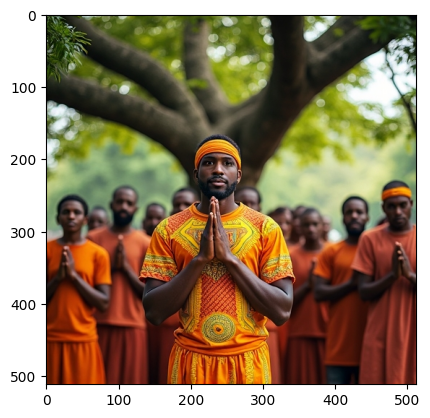

In [11]:
# ------------------------------
# test loading dataset 
# jackyhate/text-to-image-2M 
# ------------------------------

from datasets import load_dataset
base_url = "https://huggingface.co/datasets/jackyhate/text-to-image-2M/resolve/main/data_512_2M/data_{i:06d}.tar"
num_shards = 46  # Number of webdataset tar files
urls = [base_url.format(i=i) for i in range(num_shards)]
dataset = load_dataset("webdataset", data_files={"train": urls}, split="train", streaming=True)
# Example of iterating through the dataset
for image in dataset:
    print(image)
    print(image["json"]['prompt'])
    plt.imshow(image["jpg"])
    break
# Check the size of the dataset
print(dataset.info)

In [12]:
# ------------------------------
# process & save dataset to tar shards
# moved to prep_dataset.py
# ------------------------------

import os, io, tarfile

max_images = 512
img_size = 224
shard_size = 128
n_val_shard = 1

shard_dir = "./.cache/clip_data/text-to-image-2M-test"
os.makedirs(shard_dir, exist_ok=True)

text_config = TextConfig()
tokenizer = TextTokenizer(text_config)
# load dataset in streaming mode
base_url = "https://huggingface.co/datasets/jackyhate/text-to-image-2M/resolve/main/data_512_2M/data_{i:06d}.tar"
num_shards = 46
urls = [base_url.format(i=i) for i in range(num_shards)]
dataset = load_dataset("webdataset", data_files={"train": urls}, split="train", streaming=True)

resize = transforms.Compose([
    transforms.Resize((img_size, img_size)),
])

def process_sample(sample):
    # get image and prompt
    image = sample["jpg"]
    prompt = sample["json"]["prompt"]
    # resize image to img_size
    image = resize(image)
    # convert image to bytes
    img_bytes = io.BytesIO()
    image.save(img_bytes, format="JPEG")
    img_bytes.seek(0)
    # encode prompt
    tokens = tokenizer.encode(prompt)    
    # convert tokens to bytes
    token_bytes = io.BytesIO()
    torch.save(tokens, token_bytes)
    token_bytes.seek(0)
    return img_bytes, token_bytes

# process samples and create tar shards
img_index = 0
next_shard_index = 0
current_shard_count = 0
tar_file = None
tar_path = None

import time; start_time = time.time()

for sample in dataset:
    if img_index >= max_images:
        break
    # start new shard if needed
    if current_shard_count == 0:
        if tar_file is not None:
            tar_file.close()
        split = "val" if next_shard_index < n_val_shard else "train"
        # create new tar shard
        tar_path = os.path.join(shard_dir, f"text_to_image_{split}_{next_shard_index:06d}.tar")
        tar_file = tarfile.open(tar_path, "w")
        next_shard_index += 1
    # process sample
    img_bytes, token_bytes = process_sample(sample)
    # add image to tar
    img_name = f"{img_index:07d}.jpg"
    img_info = tarfile.TarInfo(name=img_name)
    img_info.size = len(img_bytes.getvalue())
    tar_file.addfile(img_info, img_bytes)
    # add tokens to tar
    token_name = f"{img_index:07d}.pth"
    token_info = tarfile.TarInfo(name=token_name)
    token_info.size = len(token_bytes.getvalue())
    tar_file.addfile(token_info, token_bytes)
    # update indices and reset shard counter if full
    img_index += 1
    current_shard_count += 1
    if current_shard_count >= shard_size:
        current_shard_count = 0

    if img_index % 1000 == 0:
        print(f"Processed {img_index}/{max_images} images")

# close final shard
if tar_file is not None:
    tar_file.close()

print(f"Done! Created {next_shard_index} shards with {img_index} images total.")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Done! Created 4 shards with 512 images total.
Time taken: 2.09 seconds


Loading image 0032768.jpg


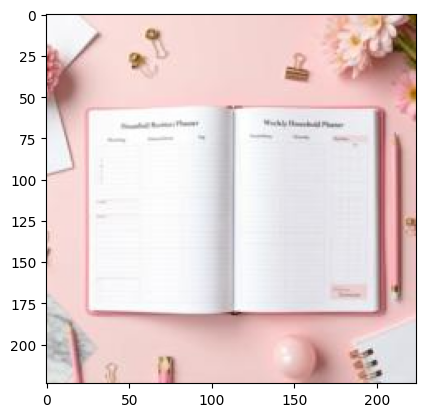

<|startoftext|>A planner with a pink cover is open to two pages. The left page is titled 'Household Routines Planner' and has a grid layout with columns for 'Day', 'Morning', 'Afternoon', and 'Evening'. The right page is titled 'Weekly Household Planner' and has a grid layout with columns for 'Monday', 'Tuesday', '<|endoftext|>


In [13]:
# ------------------------------
# test loading dataset from tar shards
# ------------------------------

import os, io, tarfile
shard_dir = "./.cache/clip_data/text-to-image-2M"

for shard in os.listdir(shard_dir):
    if not shard.endswith("train_000001.tar"):
        continue
    shard_path = os.path.join(shard_dir, shard)
    tar = tarfile.open(shard_path, "r")
    file_names = tar.getnames()
    # sample one image 
    img_name = file_names[0]
    print(f"Loading image {img_name}")
    img_bytes = tar.extractfile(img_name).read()
    img = Image.open(io.BytesIO(img_bytes))
    plt.imshow(img)
    plt.show()
    # sample one label
    token_name = file_names[1]
    token_bytes = tar.extractfile(token_name).read()
    tokens = torch.load(io.BytesIO(token_bytes), map_location='cpu')
    print(tokenizer.decode(tokens))
    break

In [14]:
# ------------------------------
# basic data loader
# ------------------------------

# moved to dataloader.py
from dataloader import DataLoaderLite

# # image to tensor
# itot = transforms.ToTensor()

# def load_shard(shard_path, verbose = False):
#     data = {}
#     with tarfile.open(shard_path, "r") as tar:
#         for member in tar.getmembers():
#             if member.isfile():
#                 f = tar.extractfile(member)
#                 data[member.name] = f.read()
#     if verbose: print(f"loaded {len(data)} files ({len(data) // 2} image-text pairs) from {shard_path.split('/')[-1]}\n-----")
#     return data

# class DataLoaderLite:
#     def __init__(self, B, rank, world_size, split = 'train', verbose = True):
#         self.B = B
#         self.rank = rank
#         self.world_size = world_size
#         self.verbose = verbose

#         assert split in ['train', 'val'], "split must be either 'train' or 'val'"
#         self.split = split

#         # TODO: replace os.getcwd() with os.path.dirname(os.path.abspath(__file__))
#         data_dir = os.path.join(os.getcwd(), '.cache', 'data', 'text-to-image-2M')
#         shards = [f for f in os.listdir(data_dir) if f.startswith(f'text_to_image_{self.split}') and f.endswith('.tar')]
#         shards = [os.path.join(data_dir, f) for f in shards]
#         self.shards = sorted(shards)
#         self.shard_count = len(self.shards)
#         assert self.shard_count > 0, f"no shards found for {split} split"
#         if self.verbose: print(f"Found {len(self.shards)} shards for {split} split")

#         # set initial state
#         self.reset()
        
#     def reset(self):
#         self.shard_index = 0
#         self.data = load_shard(self.shards[self.shard_index])
#         self.files = sorted(self.data.keys())
#         self.current_position = self.rank * (self.B * 2)
    
#     def next_batch(self):
#         B = self.B
#         images, tokens = [], []
#         for i in range(B):
#             img_name = self.files[self.current_position + i*2]
#             token_name = self.files[self.current_position + i*2 + 1]
#             img = Image.open(io.BytesIO(self.data[img_name]))
#             images.append(itot(img))
#             tokens.append(torch.load(io.BytesIO(self.data[token_name]), map_location='cpu'))
#         labels = torch.stack(tokens)
#         images = torch.stack(images)
#         self.step(1)
#         return labels, images

#     def next_shard(self):
#         self.shard_index = (self.shard_index + 1) % self.shard_count
#         self.data = load_shard(self.shards[self.shard_index], verbose = self.verbose)
#         self.files = sorted(self.data.keys())
#         self.current_position = self.rank * (self.B * 2)

#     def step(self, num_steps = 1):
#         for i in range(num_steps):
#             B, world_size, rank = self.B, self.world_size, self.rank
#             self.current_position += (2 * B) * world_size
#             # reset if next batch would be out of bounds
#             next_position = self.current_position + (2 * B) * world_size
#             if next_position > len(self.files):
#                 self.next_shard()
#                 self.current_position = rank * (2 * B)

B = 128

print(f"timing with B = {B}\n-----")
start_time = time.time()
train_loader = DataLoaderLite(B, 0, 1, split = 'train', verbose = True)
end_time = time.time()
print(f"⏱️ initialize DataLoaderLite: {end_time - start_time:.2f} seconds\n-----")
# discard warmup batch 
labels, images = train_loader.next_batch()
# timed batch
start_time = time.time()
labels, images = train_loader.next_batch()
print(images.shape, labels.shape)
end_time = time.time()
print(f"⏱️ get batch: {end_time - start_time:.2f} seconds")

timing with B = 128
-----
found 59 shards for train split
⏱️ initialize DataLoaderLite: 1.15 seconds
-----
torch.Size([128, 3, 224, 224]) torch.Size([128, 77])
⏱️ get batch: 0.05 seconds


In [ ]:
# ------------------------------
# basic training loop
# improved in train.py
# ------------------------------

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
ddp = False
master_process = True

# batch parameters
total_batch_size = 64 # TODO: tune, probably needs to be ~1024
B = 64 if device == "cuda" else 8 if device == "mps" else 1 # TODO: tune 
assert total_batch_size % B == 0, "total_batch_size must be divisible by B"
embed_accum_steps = total_batch_size // B
# data loaders
train_loader = DataLoaderLite(B, 0, 1, split = 'train', verbose = True)
val_loader = DataLoaderLite(B, 0, 1, split = 'val', verbose = True)

def evaluate(model, device, val_loader):
    t0 = time.time()
    model.eval()
    val_loader.reset()
    with torch.no_grad():
        label_embs, image_embs = [], []
        for _ in range(embed_accum_steps):
            labels, images = val_loader.next_batch()
            labels, images = labels.to(device), images.to(device)
            label_emb, image_emb = model.embed(labels, images)
            label_embs.append(label_emb)
            image_embs.append(image_emb)
        label_embs = torch.cat(label_embs, dim=0)
        image_embs = torch.cat(image_embs, dim=0)
        loss = model.loss(label_embs, image_embs)
    t1 = time.time()
    dt = t1 - t0
    if master_process:
        print(f"-----\nval loss: {loss.item():.4f} | eval_time: {dt:.2f}s\n-----")

# initialize model
model = CLIP(TextConfig(), VisionConfig())
model = model.to(device)

# set up optimizer & learning rate schedule
max_lr = 3e-4 # TODO: update
min_lr = max_lr * 0.1
img_per_epoch = 2097152
steps_per_epoch = img_per_epoch // total_batch_size # 2k steps with total_batch_size = 1024
n_epoch = 1
max_steps = steps_per_epoch * n_epoch 
optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr) # TODO: update
warmup_steps = max_steps * 0.02 # 2% warmup steps
# cosine decay
def get_lr(step):
    # start with linear warmup
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    # Cosine decay
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)
    # base case: min_lr
    return min_lr

# train
print(f"training for {max_steps} steps")
# baseline
evaluate(model, device, val_loader)

for step in range(max_steps):
    t0 = time.time()
    model.train()
    optimizer.zero_grad(set_to_none=True)
    label_embs, image_embs = [], []
    for _ in range(embed_accum_steps):
        labels, images = train_loader.next_batch()
        labels, images = labels.to(device), images.to(device)
        label_emb, image_emb = model.embed(labels, images)
        label_embs.append(label_emb)
        image_embs.append(image_emb)
    label_embs = torch.cat(label_embs, dim=0)
    image_embs = torch.cat(image_embs, dim=0)
    loss = model.loss(label_embs, image_embs)
    loss.backward()
    # TODO: decide if we need gradient clipping 
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    t1 = time.time()
    dt = t1 - t0
    img_per_sec = (B * embed_accum_steps) / dt
    print(f"step {step} |  trn_loss: {loss.item():.4f} | norm: {norm:.4f} | lr: {lr:.2e} | dt: {dt:.2f}s | img/s: {img_per_sec:.2f}")
    if (step + 1) % 10 == 0:
        evaluate(model, device, val_loader)

loading configs from checkpoint
configs updated from checkpoint
checkpoint model loaded successfully


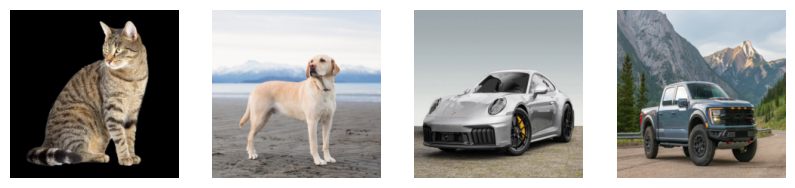

cat | dog | coupe | truck


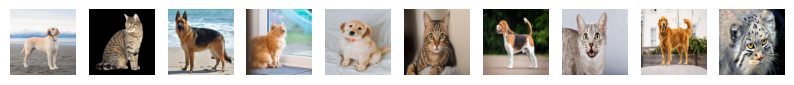

dog | cat | dog | cat | dog | cat | dog | cat | cat | cat


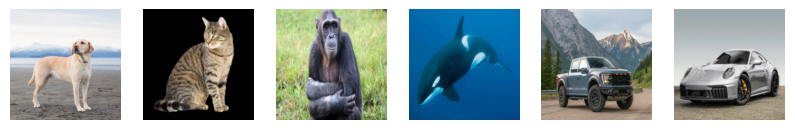

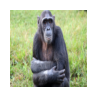

In [30]:
# ------------------------------
# utils for testing pretrained model
# ------------------------------

def load_pretrained_model(checkpoint):
    from checkpoint_manager import update_configs_from_checkpoint, load_checkpoint_model_only

    device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
    checkpoint_dir = os.path.join(os.getcwd(), '.cache', 'clip_data', 'checkpoints')
    checkpoint_path = os.path.join(checkpoint_dir, f"{checkpoint}")

    text_config, vision_config = TextConfig(), VisionConfig()
    update_configs_from_checkpoint(checkpoint_path, text_config, vision_config, device)
    model = CLIP(text_config, vision_config)
    load_checkpoint_model_only(checkpoint_path, model, device)
    return model, device

# image utils 
# transforms
itot = transforms.Compose([
  transforms.Resize((vision_config.img_size, vision_config.img_size)),
  transforms.ToTensor()
])
ttoi = transforms.ToPILImage()

# sample image loader
def load_image(name):
    dir = "./data/sample"
    file = f"{dir}/{name}"
    return itot(Image.open(file).convert("RGB"))

def load_images(names):
    images = []
    for name in names:
        images.append(load_image(name))
    return torch.stack(images)

def show_tensor_image(image_tensor):
    image = ttoi(image_tensor)
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def show_tensor_images(images_tensor):
    images = [ttoi(images_tensor[i]) for i in range(images_tensor.shape[0])]
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# sample label encoder
prompt_templates = [
    "a photo of a ",
    "an image of a ",
    "a picture of a ",
]

def encode_labels(labels):
    return torch.stack([enc.encode(label) for label in labels], dim=0)

def show_labels(labels_tensor):
    labels = [tokenizer.decode(labels_tensor[i]) for i in range(labels_tensor.shape[0])]
    print("\n".join(labels))

def add_prompts(labels):
    prompts = [template + label for template in prompt_templates for label in labels]
    return encode_labels(prompts)

def strip_prompts(labels):
    stripped_labels = []
    for label in labels:
        stripped = False
        for template in prompt_templates:
            if label.startswith(template):
                stripped_labels.append(label[len(template):])
                stripped = True
                break
        if not stripped:
            stripped_labels.append(label)
    return stripped_labels

# retrieval utils

def get_top_label(model, images, labels):
    labels = add_prompts(labels)
    label_embs, image_embs = model.embed(labels, images)
    sim = image_embs @ label_embs.T # len(images), len(labels)
    sorted_indices = sim.argsort(dim=1, descending=True) # len(images), len(labels)
    top_idx = sorted_indices[:, 0] # len(images)
    top_labels_encoded = labels[top_idx] # len(images), D(77)
    top_labels = [enc.decode(top_labels_encoded[i], include_special_tokens=False) for i in range(len(top_labels_encoded))]
    return " | ".join(strip_prompts(top_labels))

def get_top_image(model, images, label):
    label = encode_labels([label])
    label_embs, image_embs = model.embed(label, images)
    sim = label_embs @ image_embs.T # 1, len(images)
    sorted_indices = sim.argsort(dim=1, descending=True) # 1, len(images)
    top_idx = sorted_indices[:, 0] # 1
    top_image = images[top_idx][0] # 3, 224, 224
    return top_image

# ------------------------------
# test pretrained model
# ------------------------------

model, device = load_pretrained_model("run3")

# given a set of images, pick the top label
imgs = load_images(["cat.jpg", "dog.jpg", "car.jpg", "truck.jpg"])
show_tensor_images(imgs)
labels = ["dog", "cat", "bird", "coupe", "truck", "girl", "boy"]
print(get_top_label(model, imgs, labels))

# dog vs cat classification
imgs = load_images(["dog.jpg", "cat.jpg", "dog2.jpg", "cat2.jpg", "dog3.jpg", "cat3.jpg", "dog4.jpg", "cat4.jpg", "dog5.jpg", "cat5.jpg"])
show_tensor_images(imgs)
labels = ["dog", "cat"]
print(get_top_label(model, imgs, labels))

# given a label, pick the matching image
imgs = load_images(["dog.jpg", "cat.jpg", "chimp.jpg", "whale.jpg", "truck.jpg", "car.jpg"])
label = "chimpanzee"
show_tensor_images(imgs)
show_tensor_image(get_top_image(model, imgs, label))

llama


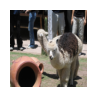

In [ ]:
# ------------------------------
# build ImageNet eval
# ------------------------------

# convenience 
def show_imagenet_pair(imagenet_loader, idx=1):
    img, label = imagenet_loader.get_pair(idx)
    img = ttoi(img)
    print(enc.decode(label, include_special_tokens=False))
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# load imagenet batches
class ImageNetLoader:
    def __init__(self, B=None):
        self.imagenet_dir = os.path.join(os.getcwd(), '.cache', 'clip_data', 'ILSVRC2012')
        self.label_path = os.path.join(self.imagenet_dir, f'val_ground_truth.txt')
        self.class_map_path = os.path.join(self.imagenet_dir, 'class_map.txt')

        self.labels, self.class_map = [], {}
        with open(self.label_path, 'r') as f:
            self.labels = [int(line) for line in f.read().splitlines()]
        with open(self.class_map_path, 'r') as f:
            class_map_raw = f.read().splitlines()
            for line in class_map_raw:
                id, idx, name = line.split()
                name = name.replace("_", " ")
                self.class_map[int(idx)] = name

        self.pos = 0
        self.n_class = len(self.class_map)
        self.n_img = 50_000 # number of validation images
        self.B = self.n_class if B is None else B # default to 1k to match n_class
        assert self.n_img % self.B == 0, "n_img can't be divided into batches of size B"

    def get_class_name(self, idx=1):
        assert 0 < idx <= self.n_img, f"idx must be between 1 and {self.n_img}"
        return self.class_map[int(self.labels[idx-1])] # 0-indexed

    def get_class_with_prompt(self, idx=1):
        prompt = "an image of a "
        return prompt + self.get_class_name(idx)

    def get_encoded_class(self, idx=1):
        return enc.encode(self.get_class_with_prompt(idx))

    def get_img(self, idx=1):
        assert 0 < idx <= self.n_img, f"idx must be between 1 and {self.n_img}"
        img_path = os.path.join(self.imagenet_dir, 'val', f'ILSVRC2012_val_{idx:08d}.JPEG')
        return itot(Image.open(img_path))
    
    def get_pair(self, idx=1):
        img = self.get_img(idx)
        label = enc.encode(self.get_class_name(idx))
        
        return img, label

    def get_batch_count(self):
        return self.n_img // self.B

    def get_batch(self):
        """returns B images, the full set of classes, and the index of each image's class"""
        imgs, targets = torch.zeros(self.B, 3, 224, 224), torch.zeros(self.B, dtype=torch.long)        
        for i in range(self.B):
            imgs[i] = self.get_img(self.pos + i + 1) # get_img is 1-indexed
            targets[i] = self.labels[self.pos + i] - 1 # convert targets to 0-indexed
        self.pos += self.B
        classes = torch.stack([self.get_encoded_class(i+1) for i in range(self.n_class)]) # class_map is 1-indexed
        return imgs, classes, targets

class ImageNetEval:
    def __init__(self, model, size=50_000):
        self.model = model
        self.device = next(model.parameters()).device
        self.size = size
        self.B = min(size, 100)
        self.n_batch = self.size // self.B
        self.imagenet = ImageNetLoader(B=self.B)

    def eval(self):
        n_correct = 0

        for i in range(self.n_batch):
            print(f"evaluating batch {i+1} of {self.n_batch} (n_correct: {n_correct} / {self.size} so far)")
            images, classes, targets = self.imagenet.get_batch()
            images = images.to(self.device)
            classes = classes.to(self.device)
            targets = targets.to(self.device)
            # get similarity matrix of images and classes
            label_embs, image_embs = self.model.embed(classes, images)
            sim = image_embs @ label_embs.T
            # get index of most similar class for each image
            sorted_indices = sim.argsort(dim=1, descending=True)
            top_idx = sorted_indices[:, 0]
            # for j in range(self.B):
            #     # img = ttoi(images[j])
            #     # plt.figure(figsize=(1, 1))
            #     # plt.imshow(img)
            #     # plt.axis("off")
            #     # plt.show()
            #     print(f"predicted: {enc.decode(classes[top_idx[j]], include_special_tokens=False)} | target: {enc.decode(classes[targets[j]], include_special_tokens=False)}")
            # compare vs ImageNet target class index
            n_correct += (top_idx == targets).sum().item()

        return n_correct / self.size

imagenet = ImageNetLoader(B=1000)
show_imagenet_pair(imagenet, 50000)

In [ ]:
imagenet_eval = ImageNetEval(model, size = 500)
print(f"imagenet eval: {imagenet_eval.eval()*100:.2f}%")

evaluating batch 1 of 1000 (n_correct: 0 / 50000 so far)
evaluating batch 2 of 1000 (n_correct: 1 / 50000 so far)
evaluating batch 3 of 1000 (n_correct: 1 / 50000 so far)
